In [5]:
import sys
import os
import pandas as pd

# Get the absolute path to the project root (one folder above notebooks/)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_path = os.path.join(project_root, "data")

# Add project root to sys.path
sys.path.append(project_root)

from src.data_utils import load_fake_real_dataset, basic_dataset_info

# Load dataset
df = load_fake_real_dataset(data_path)

# Run info function
basic_dataset_info(df)

df.head()



=== DATASET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
 5   content  44898 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.1+ MB
None

=== FIRST 5 ROWS ===
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee 

,title,text,subject,date,label,content,word_count
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,Donald Trump Sends Out Embarrassing New Year’...,507
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,Drunk Bragging Trump Staffer Started Russian ...,313
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,Sheriff David Clarke Becomes An Internet Joke...,595
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,Trump Is So Obsessed He Even Has Obama’s Name...,458
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,Pope Francis Just Called Out Donald Trump Dur...,431


# Clean text & prepare train/val/test split

In [6]:
from src.preprocessing import apply_cleaning, split_dataset

# Clean the dataset
df = apply_cleaning(df)
df[["content", "clean_content"]].head()


,content,clean_content
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump sends out embarrassing new year s...
1,Drunk Bragging Trump Staffer Started Russian ...,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,sheriff david clarke becomes an internet joke ...
3,Trump Is So Obsessed He Even Has Obama’s Name...,trump is so obsessed he even has obama s name ...
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis just called out donald trump duri...


In [ ]:
train_df, val_df, test_df = split_dataset(df)

len(train_df), len(val_df), len(test_df)

train_df.to_csv("../data/train.csv", index=False)
val_df.to_csv("../data/val.csv", index=False)
test_df.to_csv("../data/test.csv", index=False)

(31428, 6735, 6735)

# Build the TF-IDF + Logistic Regression Model

### Load train/val/test

In [11]:
train_df = pd.read_csv("../data/train.csv")
val_df = pd.read_csv("../data/val.csv")
test_df = pd.read_csv("../data/test.csv")

### Clean NaN After Reloading

In [12]:
train_df["clean_content"] = train_df["clean_content"].fillna("")
val_df["clean_content"] = val_df["clean_content"].fillna("")
test_df["clean_content"] = test_df["clean_content"].fillna("")

train_df["label"] = train_df["label"].fillna(-1).astype(int)
val_df["label"] = val_df["label"].fillna(-1).astype(int)
test_df["label"] = test_df["label"].fillna(-1).astype(int)

### Validation: Check for NaNs

In [13]:
train_df["clean_content"].isna().sum(), val_df["clean_content"].isna().sum(), test_df["clean_content"].isna().sum()

(np.int64(0), np.int64(0), np.int64(0))

### Filter invalid rows

In [14]:
train_df = train_df[train_df["clean_content"].notna()]
val_df = val_df[val_df["clean_content"].notna()]
test_df = test_df[test_df["clean_content"].notna()]

### Train the model

In [15]:
from src.model_tfidf import build_tfidf_logreg_model, train_model, evaluate_model

pipe = build_tfidf_logreg_model()

pipe = train_model(
    pipe,
    train_df["clean_content"],
    train_df["label"]
)

### Evaluate

In [16]:
print("Validation results:")
evaluate_model(pipe, val_df["clean_content"], val_df["label"])

print("Test results:")
evaluate_model(pipe, test_df["clean_content"], test_df["label"])

Validation results:

Accuracy: 0.9921

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3522
           1       0.99      0.99      0.99      3213

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735

Test results:

Accuracy: 0.9932

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3523
           1       0.99      0.99      0.99      3212

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



0.9931700074239049

### Save the model

In [18]:
from src.model_tfidf import save_model

save_model(pipe, "../models/tfidf_logreg.joblib")

Model saved to ../models/tfidf_logreg.joblib


# Extracting Feature Importance (Fake vs Real Words)

In [19]:
from src.feature_importance import extract_top_features, plot_top_features

fake_top, real_top = extract_top_features(pipe, top_n=20)
fake_top, real_top

(                  word      coef
 46690            video -9.309375
 46622              via -8.459672
 33330        read more -4.768930
 43044             this -4.495108
 22879             just -4.462665
 27860            obama -4.424564
 33327             read -4.392317
 46317               us -4.229052
 32088  president trump -4.161180
 19918            image -4.082516
 18829          hillary -4.019780
 16887              gop -4.002674
 47552            watch -3.959392
 49805              you -3.919081
 14625   featured image -3.883679
 14624         featured -3.872589
 2198           america -3.644529
 42393           the us -3.628438
 19928        image via -3.473199
 9208               com -3.325896,
                      word       coef
 34560             reuters  18.365162
 35341                said  10.400223
 47527  washington reuters   8.032241
 35431             said on   7.281823
 34628         reuters the   5.107456
 29445        on wednesday   4.968826
 47509          was

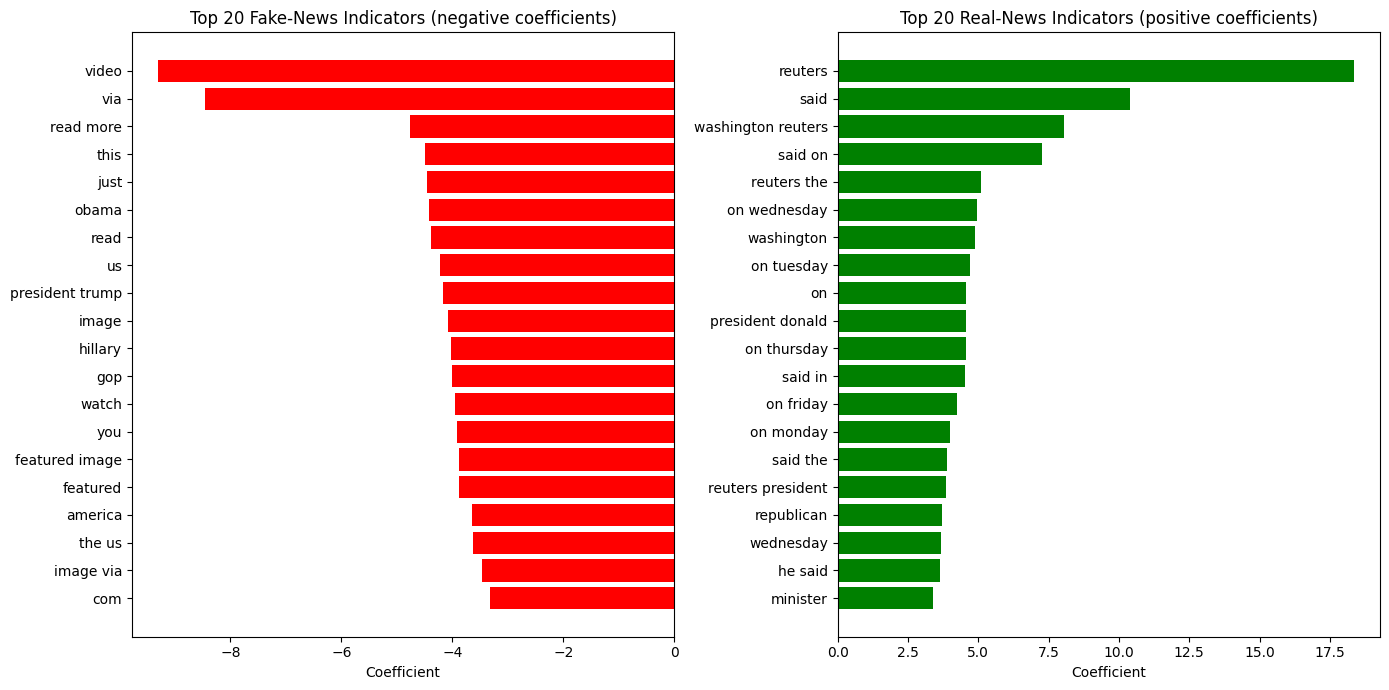

In [20]:
plot_top_features(fake_top, real_top, top_n=20)